In [ ]:
# Librerías 
import numpy as np 
import scipy.fft as sft 
import matplotlib.pyplot as plt
from PIL import Image as im
import skimage as sk
import scipy.ndimage as sc

In [ ]:
def tajada(M1,M2,x,y):
    """
    Esta funcion permite recortar una seccion centrada en x, y del array M1 de
    tamaño igual al array M2. Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo del que se recorta una sección.
    M2 : Array Numpy
        Arreglo que determina el tamaño del recorte.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a recortar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M2.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz recortada debe ser mas pequeña que la original')
    MC=M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]
    return MC

def fusion(M1,M2,x,y):
    """
    Esta funcion permite insertar M2 a una seccion centrada en (x, y) del array M1.
    Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo al que se inserta una sección.
    M2 : Array Numpy
        Arreglo a insertar.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a insertar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M1.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz a instertar debe ser mas pequeña que la original')
    M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]=M2
    MC=np.copy(M1)
    return MC

def convft(U,H,dx):
    """
    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    U2=sft.fft2(sft.fftshift(U))*(dx**2)
    U2=H*U2
    U2=sft.ifftshift(sft.ifft2(U2)*(1/dx**2))
    return U2


def circ(x,y,d): # FUNCION CÍRCULO
    out = np.zeros((len(x),len(y)))
    for cont in range(0,len(x)):
        for cont2 in range(0,len(y)):
            out[cont,cont2]=int(np.abs(np.sqrt(x[cont,cont2]**2+y[cont,cont2]**2)/d)<=1)
    return out
    
def propTF(u1,L,lam,z): # PROPAGADOR BASADO EN LA FUNCIÓN DE TRANSFERENCIA
    # propagation - transfer function approach
    # assumes same x and y side lengths and
    # uniform sampling
    # u1 - source plane field
    # L - source and observation plane side length
    # lambda - wavelength
    # z - propagation distance
    # u2 - observation plane field
    N=len(u1[0,:]) 
    dx=L/N
    k=2*np.pi/lam
    fx=np.arange(-1/(dx*2),1/(dx*2),1/L)  
    FX, FY = np.meshgrid(fx, fx);
    H=np.exp(-1j*np.pi*lam*z*(FX**2+FY**2))
    H= np.fft.fftshift(H)
    U1= np.fft.fft2(np.fft.fftshift(u1))
    U2= H*U1
    u2=np.fft.ifftshift(np.fft.ifft2(U2))
    return u2

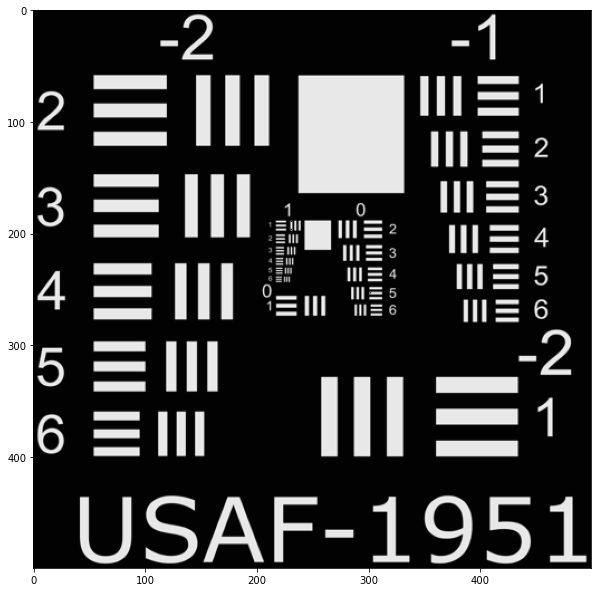

In [ ]:
'''Carguemos la imagen a trabajar'''
I = im.open('./usaf.bmp')

'''normalizar la imagen'''
I=I.resize([500,500]) # El objeto solo ocupará este ventana. Es necesario para que haya suficiente espacio a la hora de reconstruir el holograma
I=1-np.asarray(I)     # Cambio de contraste en la imagen usaf. 
I=I*1.# Convierte nuestro objeto en una matriz de float.
A = np.random.rand(500,500)
I1 = np.sqrt(I)*np.exp(1j*2*np.pi*A)
'''Campo de Entrada'''
ug=np.zeros([1000,1000])*1j #Campo de ceros, ventana 1000 x 1000 muestras. 

ug=fusion(ug,I1,0,0) #Pegamos el campo(objeto difuso) en el campo de entrada

'''máscara aletoria de fase'''
#A = np.random.rand(1000, 1000)
#ug = ug*A
'''hacemos la TFI para obtener el DCO'''
DCO = sft.fftshift(sft.ifft2(sft.fftshift(ug))) 

plt.figure(figsize=(10,12))
plt.imshow(I,cmap='gray')

(1000, 1000)


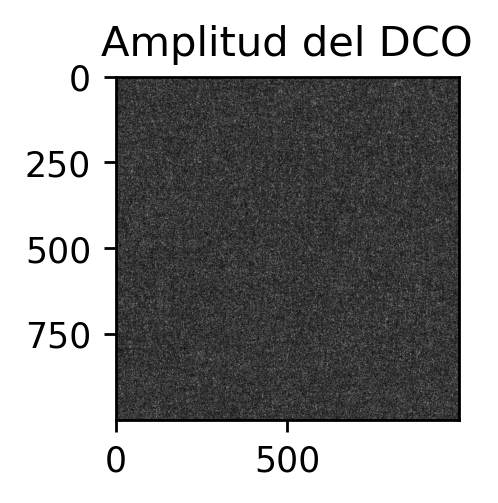

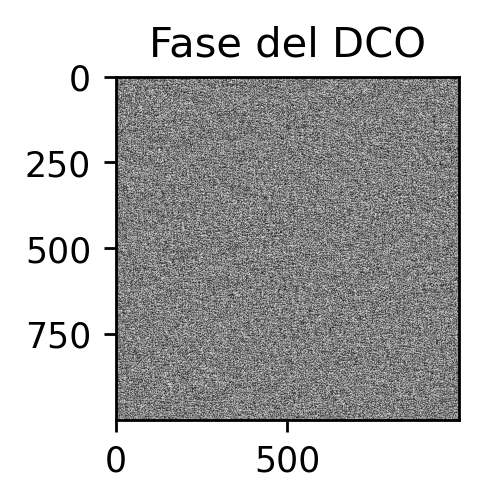

In [ ]:
'''Amplitud del dato de campo óptico'''
amplitud_DCO = np.abs(DCO)
print(np.shape(amplitud_DCO))
'''Fase del dato de campo óptico'''
fase_DCO=(np.angle(DCO)+np.pi)/(2*np.pi)

fig = plt.figure(dpi=250) # --> Gráfica de lo que registraría la camara CCD
ax1 = fig.add_subplot(2, 1, 1)
pos1 =ax1.imshow(amplitud_DCO,cmap='gray')
ax1.title.set_text('Amplitud del DCO')

fig = plt.figure(dpi=250)
ax1 = fig.add_subplot(2, 1, 2)
pos1 =ax1.imshow(fase_DCO,cmap='gray')
ax1.title.set_text('Fase del DCO')

In [ ]:
'''
    El campo objeto es el resultado de la TF del DCO, la diferencia entre la TF y la TFI
    en este caso es para la inversión del objeto 
'''
ug_objeto=sft.fftshift(sft.fft2(sft.fftshift(DCO)))
'''Campo de Entrada donde vamos a pegar nuestro DCO'''
ugv=np.zeros([2001,2001])*1j 
ugv1=fusion(ugv,ug_objeto,0,0) #La ventana para evitar réplicas periódicas.

'''Paramétros'''
N = 1000 
N2 = N*2 #N tamaño del holograma, tamaño de la ventana 
wl = 532e-9 #Longitud de onda
k=2*np.pi/wl #Número de onda
dx = 8e-6 

zc= dx*N2/wl
print(zc,'Distancia critica')

#Paramétros no convenientes
#N2 = 0.26*2 #metros, al final es mi L
#N = len(ugv1[0,:])
#dx= N2/N
############
aumento= 0.8
y1 = 2*((dx*dx*N2)/wl)
y2 = y1*aumento #Distancia imagen 
f = (y1*y2)/(y1 + y2) #Foco imagen
#zc =dx*N2/wl #Distancia critica
print(y1, ':Distancia plano objeto')
print(y2, ':Distancia plano imagen')

30075.18796992481 Distancia critica
0.48120300751879697 :Distancia plano objeto
0.24060150375939848 :Distancia plano imagen


In [ ]:
'''
    Proceso de Escalado óptico
'''
# sistema de coordenadas
x=np.arange(-N2*dx/2,N2*dx/2,dx)
X,Y = np.meshgrid(x, x);
# Se propaga el campo objeto una distancia zo 
u2=propTF(ugv1,N2,wl,y1)
#Se multiplica por la fase de la lente
ww=4
uout=u2*np.exp(-1j*k/(2*f)*(X**2+Y**2));
#Se propaga una distancia zi hasta el plano imagen
u4=propTF(uout,N2,wl,y2)

DCO_M08=u4

'''
    TF del campo objeto después de haber escalado de esta forma obtenemos el DCO escalado
'''
DCO_M08=sft.fftshift(sft.fft2(sft.fftshift(DCO_M08)))

'''El recorte se hace de [800,800] ya que estamos trabajando con una magnificación de 0.8'''
RM08=tajada(DCO_M08,np.zeros([800,800]),0,0)  

'''Amplitud del dato de campo óptico'''
amplitud_DCO08 = np.abs(RM08)
amplitud_DCO08 = amplitud_DCO08/np.max(np.max(amplitud_DCO08))*1. #Normalizo la amplitud
amplitud_DCO08 = amplitud_DCO08*255. 

'''Fase del dato de campo óptico'''
fase_DCO08=(np.angle(RM08)+np.pi)/(2*np.pi) #Normalizo la fase
fase_DCO08= fase_DCO08*255. 

'''Guardamos la imagen de la amplitud'''
amplitud08=im.fromarray(np.uint8(amplitud_DCO08))
amplitud08.save('amplitudM08.bmp')

'''Guardamos la imagen de la fase'''
fase08=im.fromarray(np.uint8(fase_DCO08))
fase08.save('faseM08.bmp')

In [ ]:
'''En este paso metemos el método de la cuantización'''

def quantize(U,bits): 
    '''
        La función quantize se ingresa un campo normalizado y con valores entre 0 y 255.
    '''
    bits = 2**bits 
    x1 = np.linspace(0,255,256) #Arreglo que representa los niveles de intensidad a 8 bits. 
    x2 = np.linspace(0, 255, bits) #Creó el arreglo con el que vamos a cuantizar
    '''
        Dado que introducimos una imagen bidimensional entonces debemos debemos cuantizar los valores de cada
        una de estas, mediante un muestreo uniforme. 
    '''
    Matrix = np.zeros([len(U),len(U)])
    for i in range(0,len(U)): 
        B = U[i,:]
        C = x2[np.absolute(B[:,np.newaxis]-x2).argmin(axis=1)] #Proceso de redondeo
        Matrix[i,:]= C
    
    return Matrix

'''Cargo la imagen de amplitud y la normalizo'''
amplitud08=im.open('amplitudM08.bmp')
amplitud08=np.asarray(amplitud08)
#amplitud08=amplitud08/255 
#Aquí proceso de cuantización. 
amplitud08= quantize(amplitud08,4)
amplitud08=amplitud08/255


'''Cargo la imagen de fase y la normalizo'''
fase08=im.open('faseM08.bmp')
fase08=np.asarray(fase08)
#fase08=fase08/255. 
#Aquí proceso de cuantización 
fase08= quantize(fase08,4)
fase08=fase08/255

In [ ]:
'''Proceso de reconstrucción de la imagen y escalado inverso'''
DCO08=amplitud08*np.exp(1j*2*np.pi*(fase08-0.5)) #para la reconstrucción de la imagen

'''
    Primero creamos un campo de entrada del doble del tamaño de nuestro DCO escalado dado que nuestro
    DCO_escalado a 0.8 tiene un tamaño de [800,800] creamos un espacio de [1600,1600]. Esto con el fin,
    de evitar las convoluciones periódicas en el proceso de escalado inverso. 
'''
ugv08=np.zeros([2001,2001])*1j 
ugv108=fusion(ugv08,DCO08,0,0) #La ventana para evitar réplicas periódicas. 

In [ ]:
ug_M08=sft.fftshift(sft.ifft2(sft.fftshift(ugv108))) #Objeto escalado

In [ ]:
# Se propaga el objeto escalado una distancia zo 
u208=propTF(ug_M08,N2,wl,y2)
#Se multiplica por la fase de la lente
ww=4
uout=u208*np.exp(-1j*k/(2*f)*(X**2+Y**2));
#Se propaga una distancia zi hasta el plano imagen
u4=propTF(uout,N2,wl,y1)

ug08_EI = u4 #Hasta aquí el proceso de escalado inverso

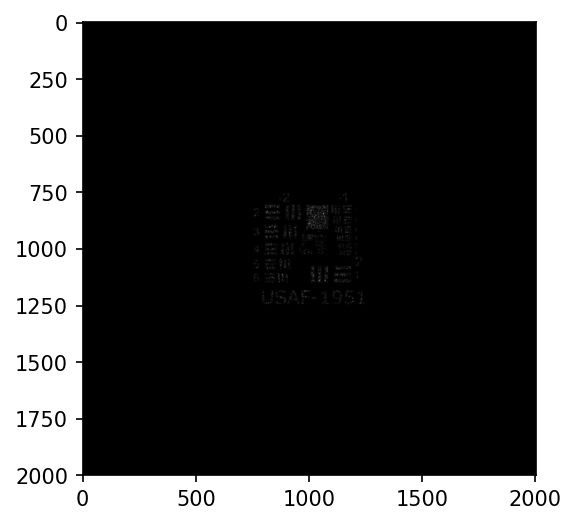

In [ ]:
'''Realizamos la transformada inversa después de hacer el proceso de escalado óptico'''

reconstruccion = ug08_EI*np.conj(ug08_EI)
reconstruccion = abs(reconstruccion)

plt.figure(dpi=150)
plt.imshow(reconstruccion, cmap='gray')

Text(0.5, 0, 'M=0.2 ; $B_c=4 bits$')

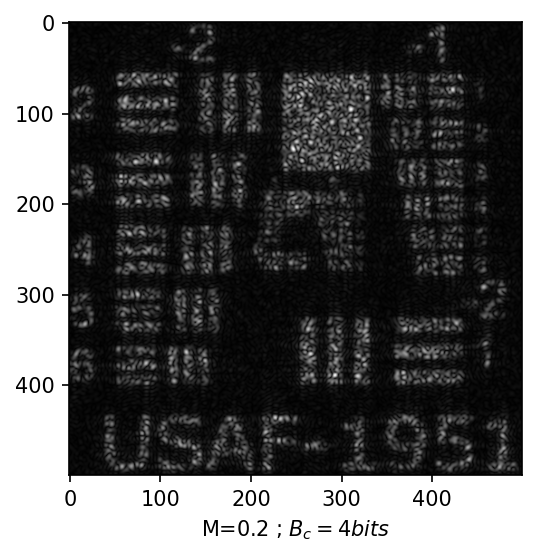

In [ ]:
'''Dato obtenido '''
ug_final=tajada(reconstruccion,np.zeros([500,500]),0,0)

plt.figure(dpi=150)
plt.imshow(ug_final**0.5, cmap='gray')
plt.xlabel('M=0.2 ; $B_c=4 bits$')

In [ ]:
#Implementación coeficiente de correlación 
def corr2(A,B):
    e=0
    s1=0
    s2=0
    Am=np.mean(A)
    Bm=np.mean(B)
    [n,m]=np.shape(A)
    for i in range(0,n):
        for j in range(0,m):
            e=e+(A[i,j]-Am)*(B[i,j]-Bm)
            s1=s1+(A[i,j]-Am)**2
            s2=s2+(B[i,j]-Bm)**2
    s=np.sqrt(s1*s2)
    return e/s

c1 = corr2(I, ug_final)
print(c1, ':coeficiente de correlación entre las imágenes')

0.5832729227702135 :coeficiente de correlación entre las imágenes


## Gráficas en términos de la magnificación y el volumen de datos: 

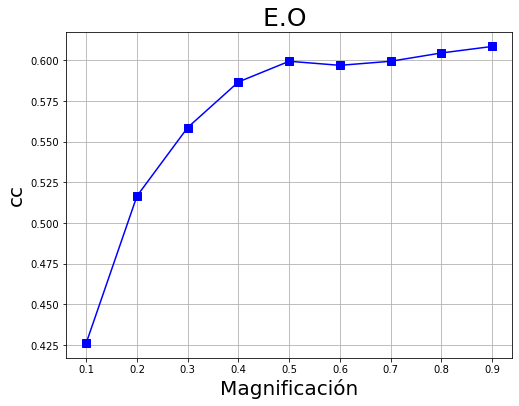

In [ ]:
cc1=np.array((0.6085,0.6045,0.5994,0.5969,0.5994,0.5867,0.5587,0.5166,0.4263))
M1= np.linspace(0.9,0.1,9)

plt.figure(figsize=(8,6))
plt.plot(M1,cc1,color='blue',marker='s',markersize=8)
plt.title('E.O ',fontsize=25)
plt.xlabel('Magnificación', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.grid()

[1.62 1.28 0.98 0.72 0.5  0.32 0.18 0.08 0.02]


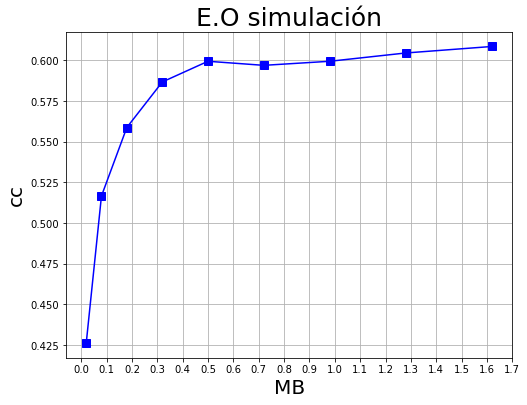

In [ ]:
def V_EOsimulado(M): 
    Xo = 1000 #px, resolución horizontal del DCO
    Yo = 1000 # px, resolución vertical del DCO 
    lista=[]
    for i in M:
        V = float(2*Xo*Yo*(i**2))
        lista.append(V)
        VEO = np.array(lista)
        
    return VEO

C = V_EOsimulado(M1)*1e-6
print(C)
plt.figure(figsize=(8,6))
plt.plot(C,cc1,color='blue',marker='s',markersize=8)
plt.title('E.O simulación',fontsize=25)
plt.xlabel('MB', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.xticks(np.arange(0.0,1.8,0.1))
plt.grid()

## Combinación método E.O y cuantización: 